In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

In [37]:
from game_assets.utils import simplify_image, save_img
from conv_rgb.model import ConvRGB

In [38]:
from pysimulacra.data import SimulacraData

ds = SimulacraData('../raw_data/sac_public_2022_06_29.sqlite')

# data = ds.fetch_all_data()

In [39]:
'raw_data/sac-000000'

'raw_data/sac-000000'

In [40]:
# 'simulacra-aesthetic-captions'

In [41]:
# img_df = ds.get_image_paths_and_prompts()

In [42]:
img_df = ds.get_image_paths_and_prompts_and_ratings()
img_df

,img_id,img_prompt,img_path,img_rating
0,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,7
1,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,1
2,6,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,4
3,5,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
4,4,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
...,...,...,...,...
176934,248438,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,5
176935,248439,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,7
176936,248440,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,6
176937,248441,avatar of a dragon knight anato finnstark yosi...,43044_avatar_of_a_dragon_knight_anato_finnstar...,5


In [67]:
def square_image(pil_img):
    
    width, height = pil_img.size # Get dimensions
    
    if width < height:
        new_width, new_height = width, width
    else:
        new_width, new_height = height, height
        
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = pil_img.crop((left, top, right, bottom))
    
    return im

In [68]:
def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

def add_border(old_img, width = 6):
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]

    new_img = Image.new("RGB", new_size, 'White')
    box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
    new_img.paste(old_img, box)
    
    return new_img

In [43]:
def shorten_path(img_path):
    name_parts = img_path.split('_')
    new_name = f'{name_parts[0]}_{name_parts[-1]}'
    return new_name

In [45]:
import regex as re
import string

def clean_png_path(file_name):
    
    file_name = file_name.replace(',', ' ')
    
    #suffix = file_name[-4:]
    
    clean_file_name = re.sub(r'[^A-Za-z0-9 ]+', '', file_name)
    
#     if clean_file_name == "":
#         clean_file_name
    
    return '_'.join(clean_file_name.split()) # + suffix


In [46]:
img_df['short_img_path'] = img_df.img_path.apply(shorten_path)

img_df['clean_prompt'] = img_df.img_prompt.apply(clean_png_path)

In [47]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download

# data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)
# data.columns = ['caption', 'url']

In [48]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device) # "ViT-B/32"

def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features


In [619]:
colour_model = ConvRGB(input_shape = (240, 240), n_cut = 8)

In [632]:
import matplotlib.pyplot as plt

def colours_as_pct(input_images):
#     print(np.min(input_images))
    images = np.add(np.ones(input_images.shape), input_images)
#   images = images + 1 # avoid dividing by zero
#     if np.min(images) == '0':
#     print('min:',  np.min(images))
#     print(type(images))
#     print(images)
#     plt.imshow(images[0] / 255)
#     plt.show()
        
#     images = np.true_divide(images, images.sum(axis=-1, keepdims=True))
    
    images = images / images.sum(axis=-1, keepdims=True)
    return images

In [633]:
def colour_encode_image(pil_img):
    
    img = pil_img.resize((240, 240))
    
    X = np.expand_dims(np.array(img), axis = 0)
    
    X = colours_as_pct(X)
    
    colour_features = colour_model(X)
    
    return colour_features

In [1161]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}')) for image_path in image_path_list]

In [1856]:
def get_common_colors(img_array_list, top_k = 256):

    all_na = np.array(img_array_list)

    all_colours, all_counts = np.unique(all_na.reshape(-1,3), axis=0, return_counts=1) 
    
    threshold = sorted(counts)[-top_k]
    
    col_palette = (colours[counts >= threshold] * 255).astype(np.uint8).reshape((16, 16, 3))
    
    return col_palette


In [1438]:
from itertools import product

def gen_color_palette(init_size):
    
    values = np.linspace(0, 255, init_size).astype(np.uint8)

    rgb_pal = np.array(list(product(values, repeat=3)))
    
    return rgb_pal

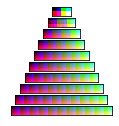

In [1857]:
# fig, axes = plt.subplots(10, 1, figsize = (2, 2))

# for i, ax in enumerate(axes.flat):
#     rgb_pal = gen_color_palette(i + 2)
#     ax.imshow(rgb_pal.reshape(i + 2, -1, 3))
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# plt.savefig('../results/color_stack.png', facecolor = 'white')

In [677]:
os.listdir('../raw_data/sac-000000/')

['25308_2.png',
 '13941_1.png',
 '26058_1.png',
 '38376_1.png',
 '1280_4.png',
 '16742_2.png',
 '7322_7.png',
 '10188_1.png',
 '13474_3.png',
 '8254_4.png',
 '15654_6.png',
 '8440_5.png',
 '16996_5.png',
 '7278_5.png',
 '31379_2.png',
 '5478_7.png',
 '9110_4.png',
 '5732_8.png',
 '31472_1.png',
 '42288_1.png',
 '20593_2.png',
 '1063_6.png',
 '17664_4.png',
 '41840_4.png',
 '18791_1.png',
 '5147_8.png',
 '33932_1.png',
 '16508_8.png',
 '3151_3.png',
 '30198_2.png',
 '36326_4.png',
 '18636_3.png',
 '16371_5.png',
 '23585_3.png',
 '38647_1.png',
 '32540_4.png',
 '27630_4.png',
 '37416_1.png',
 '19900_6.png',
 '9093_7.png',
 '28033_2.png',
 '26668_1.png',
 '6980_7.png',
 '12380_2.png',
 '10434_8.png',
 '22808_1.png',
 '11427_2.png',
 '36358_2.png',
 '38687_1.png',
 '13963_6.png',
 '8661_5.png',
 '5954_4.png',
 '409_4.png',
 '23870_1.png',
 '6509_4.png',
 '37792_1.png',
 '6650_1.png',
 '5275_7.png',
 '27165_4.png',
 '32215_4.png',
 '35419_1.png',
 '8434_8.png',
 '18002_7.png',
 '5662_1.png'

In [ ]:
# https://stackoverflow.com/questions/17728757/do-all-8-bit-colors-exist-in-24-bit-color-space-if-so-how-to-map

In [1735]:
def qcolour_encode_image(pil_img, return_img = False):
    
    # could maybe increase the number of colour features ?

    colour_palette  = gen_color_palette(4)

    colour_palette_long = colour_palette.reshape(-1)

    pal_img = Image.new('P', (16, 16))
    pal_img.putpalette(list(colour_palette_long) * 4)

    q_img = pil_img.resize((16, 16)).quantize(palette=pal_img, dither=0, method=2)
    
    new_rgb_img = Image.new('RGB', (16, 16), 0xFF)
    new_rgb_img.paste(q_img)
    
    rgb_img = np.array(new_rgb_img) 
    
    # Get used colours and counts of each
    colours, counts = np.unique(rgb_img.reshape((-1,3)), axis=0, return_counts=1)
    
    # create dict of all possible colour features
    colour_counter = {k.tobytes(): 0 for k in colour_palette}
    
    for i in range(len(colours)):

        idx = colours[i].tobytes()

        count = counts[i]

        colour_counter[idx] = count
        
    features = np.array(list(colour_counter.values()))

    if return_img:
        return features, rgb_img
    else:
        return features



In [1734]:
def plot_quantrgb(pil_img):
    
    f, axes = plt.subplots(1, 2, figsize = (12, 6))

    axes[0].imshow(pil_img)

    features, new_img = qcolour_encode_image(pil_img, return_img = True)
    axes[1].imshow(new_img)

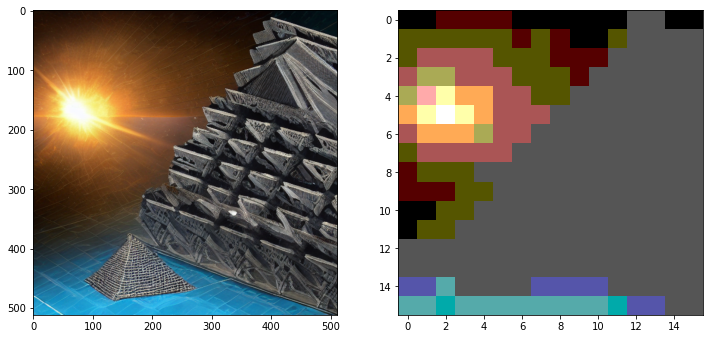

In [1858]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')

plot_quantrgb(timg)

In [1859]:
qcolour_encode_image(timg)

array([ 15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
         0,   0,   0,  14,   0,   0,   0,  27, 142,   8,   0,   0,   0,
        11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,
         0,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   7,   1,   0,   0,   0,   3,   1])

In [776]:
import os
all_imgs = os.listdir('../raw_data/sac-000000/')

exist_df = pd.DataFrame({'short_img_path': pd.Series(all_imgs)})

df = exist_df.merge(img_df, how = 'inner').drop_duplicates()

df_loop = df.sort_values('img_rating', ascending = False)[:1000]

In [640]:
# !mkdir ../raw_data/sac_images2

mkdir: ../raw_data/sac_images2: File exists


In [1812]:
# clip_features_list = []
colour_features_list = []
image_path_list = []

for i, row in tqdm(df_loop.iterrows()):
    
    img_path, caption = row['short_img_path'], row['clean_prompt']
    
    if img_path.endswith('png'):

        img = Image.open(f'../raw_data/sac-000000/{img_path}')

        if img:
            
            
#             clip_features_list.append(clip_encode_image(img)[0])

            #img = colours_as_pct(img)
            #colour_features_list.append(colour_encode_image(img)[0])
        
            colour_features_list.append(qcolour_encode_image(img))
            
            
            simple_img = simplify_image(img, num_colors = 256, size = (128, 128))
            
            simple_img = add_border(simple_img, width = 8)

            save_img(simple_img, caption, destination_folder = '../raw_data/sac_images4')

            image_path_list.append(f"{caption}.png")
#     if len(features_list) % 10 == 0:
#         print(len(features_list))
        
        

#image = get_simplified_image(url, caption, destination_folder = '../raw_data/images', num_colors = 256)

947it [00:28, 33.53it/s]


ValueError: unknown file extension: 

In [1652]:
image_embeddings = np.stack(clip_features_list)
colour_embeddings = np.stack(colour_features_list)


In [1653]:
image_embeddings[:947].shape

(947, 768)

In [1654]:
colour_embeddings[:947].shape

(947, 64)

In [1655]:
colour_embeddings

array([[14,  0,  0, ...,  0,  0,  0],
       [17,  1,  0, ...,  0,  2,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [19, 16,  0, ...,  0,  0,  0],
       [ 2,  6,  0, ...,  0,  0,  0],
       [14,  0,  0, ...,  1,  0,  0]])

In [1661]:
log_col_emb = np.ma.log(colour_embeddings[:947]).filled(0)

keep_mask = log_col_emb.mean(axis = 0) > sorted(log_col_emb.mean(axis = 0))[32]

# keep_mask = log_col_emb.sum(axis = 0) > sorted(log_col_emb.sum(axis = 0))[40]

common_colors = log_col_emb[:, keep_mask]

plt.hist(log_col_emb.mean(axis = 0)[keep_mask], bins = 50)

In [1737]:
from sklearn.preprocessing import StandardScaler

s_image_embeddings = StandardScaler().fit_transform(image_embeddings[:947])

s_colour_embeddings = StandardScaler().fit_transform(common_colors)

In [1816]:
len(image_path_list)

947

In [1758]:
both_embeddings = np.hstack([s_image_embeddings, s_colour_embeddings])

In [1817]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images4/{image_path}'))/255 for image_path in image_path_list]

In [1759]:
import pymde

image_mde = pymde.preserve_neighbors(s_image_embeddings, embedding_dim=2)
mde_image_2d = image_mde.embed()

image_mde = pymde.preserve_neighbors(both_embeddings, embedding_dim=2)
mde_both_2d = image_mde.embed()

colour_mde = pymde.preserve_neighbors(s_colour_embeddings, embedding_dim=2)
mde_colour_2d = colour_mde.embed()

Aug 22 08:30:09 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 22 08:30:09 PM: The following items have duplicates [  5   7  18  28  33  37  55  69  76  81  91  94  95 100 107 126 129 165
 185 193 218 232 262 294 295 297 348 371 373 384 385 407 438 451 462 465
 470 483 488 519 526 534 544 568 581 604 640 663 665 687 690 703 709 751
 809 810 822 823 858 871 914 916 920 931 942]
Aug 22 08:30:10 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 22 08:30:10 PM: The following items have duplicates [  4  17  18  28  34  37  44  67  69  76  79  91  94 100 121 126 129 166
 168 169 182 185 189 192 218 232 236 248 254 259 276 294 295 297 315 334
 348 353 373 407 415 425 438 465 475 483 501 515 523 538 556 566 581 604
 624 663 665 674 677 680 687 690 703 709 739 751 759 762 781 794 799 819
 822 829 839 852 867 871 896 914 916 931 935 938 942]
Aug 22 08:3

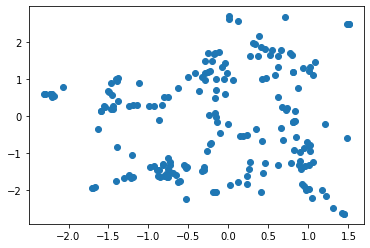

In [1760]:
import matplotlib.pyplot as plt
plt.scatter(mde_both_2d[-200:, 0], mde_both_2d[-200:, 1])

In [1763]:
from umap import UMAP

umap_image_2d = UMAP().fit_transform(s_image_embeddings)
umap_colour_2d = UMAP().fit_transform(s_colour_embeddings)

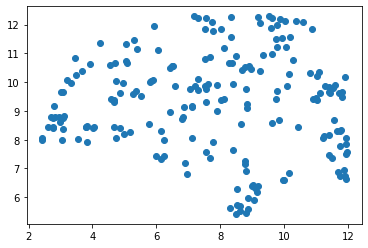

In [468]:
import matplotlib.pyplot as plt
plt.scatter(umap_colour_2d[-200:, 0], umap_colour_2d[-200:, 1])

In [1765]:
# create and fit a 2d PCA
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(s_image_embeddings)

pca.explained_variance_

# actually project only PC's
pca_image_2d = pca.transform(s_image_embeddings)

In [1861]:
pca = PCA(2)
pca_colour_2d = pca.fit_transform(s_colour_embeddings)
pca.explained_variance_

array([3.50437824, 3.08997374])

In [1693]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tqdm import tqdm
import numpy as np
from PIL import Image

def show_xy_images(x_coords, y_coords, img_arr_list, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(25, 25))
    artists = []
    for x_coord, y_coord, img in tqdm(zip(x_coords, y_coords, img_arr_list)):
        c_img = resize(img, [50,50])
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x_coord, y_coord),
                            xycoords='data',
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.stack([x_coords, y_coords], axis=1))
    ax.autoscale()

200it [00:00, 765.16it/s]


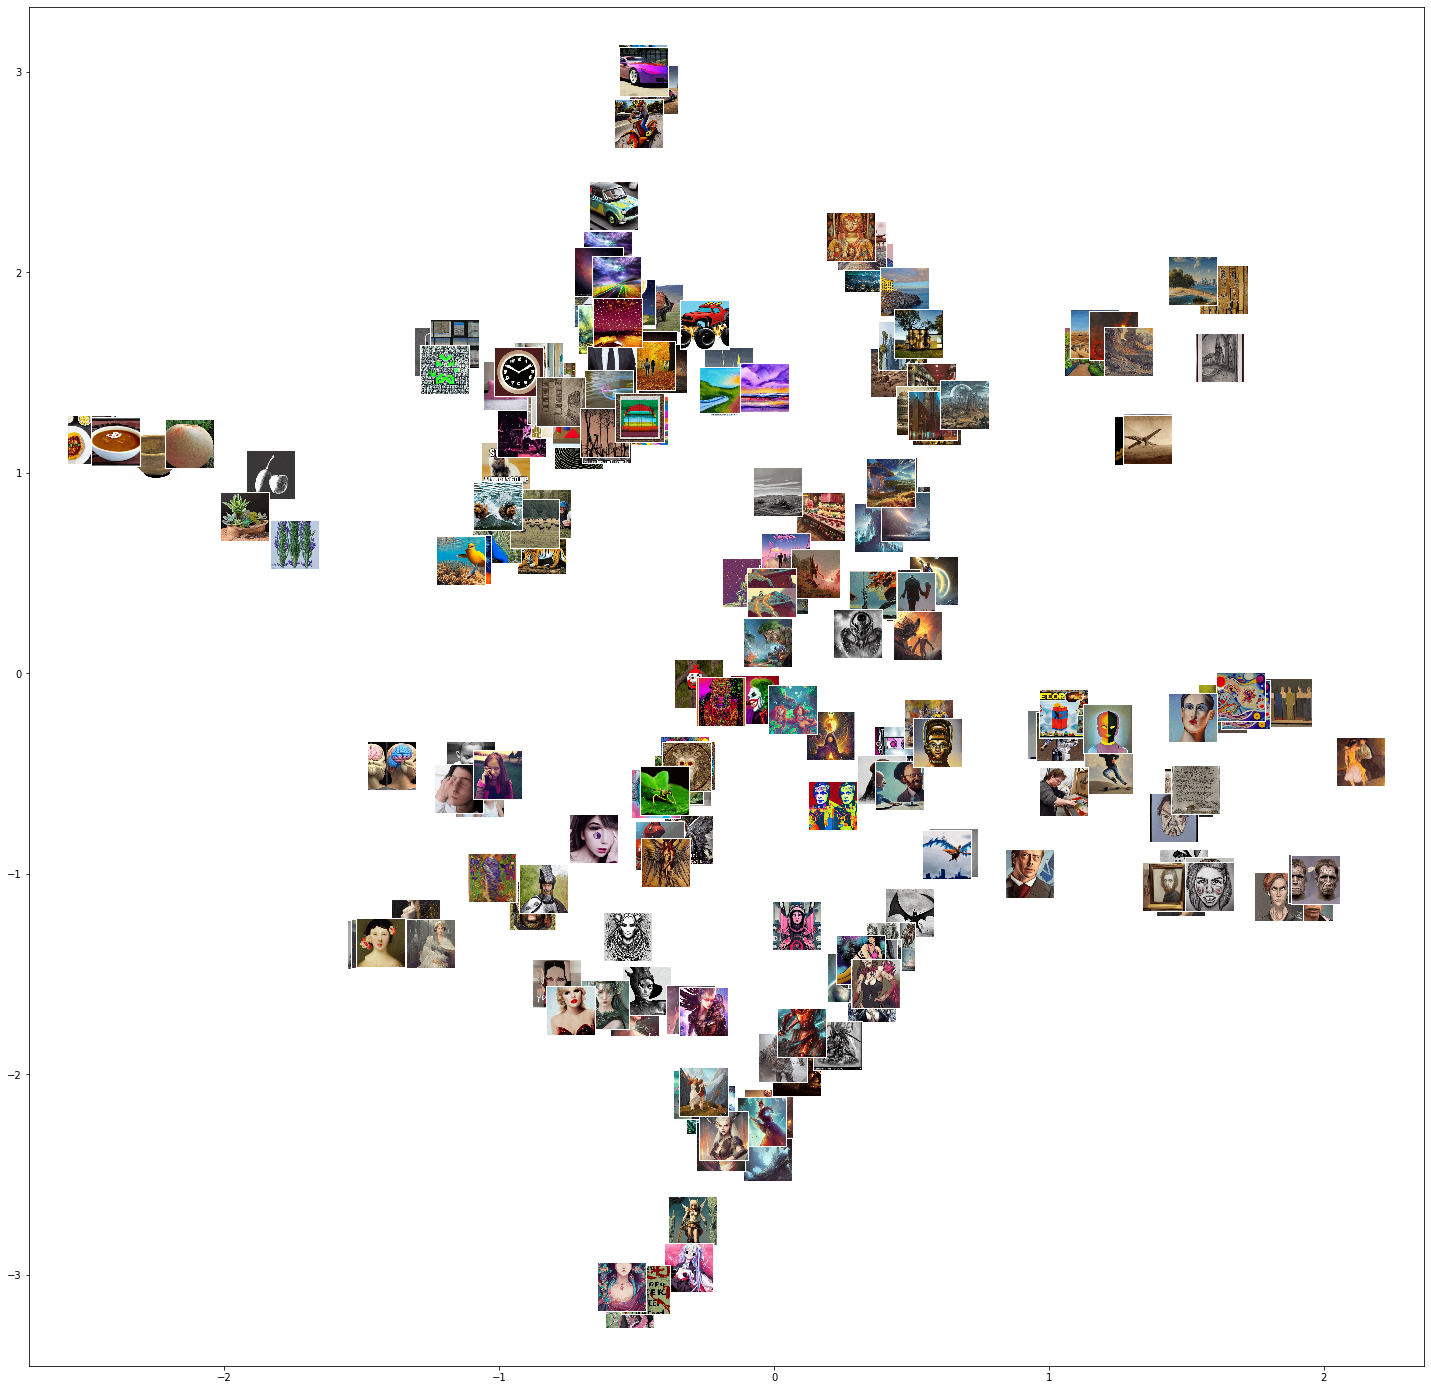

In [1768]:
show_xy_images(x_coords = mde_image_2d[-200:, 0], 
               y_coords = mde_image_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])


/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_25490/1009557772.py:1: RuntimeWarning: divide by zero encountered in log
  show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])),
200it [00:00, 1115.90it/s]


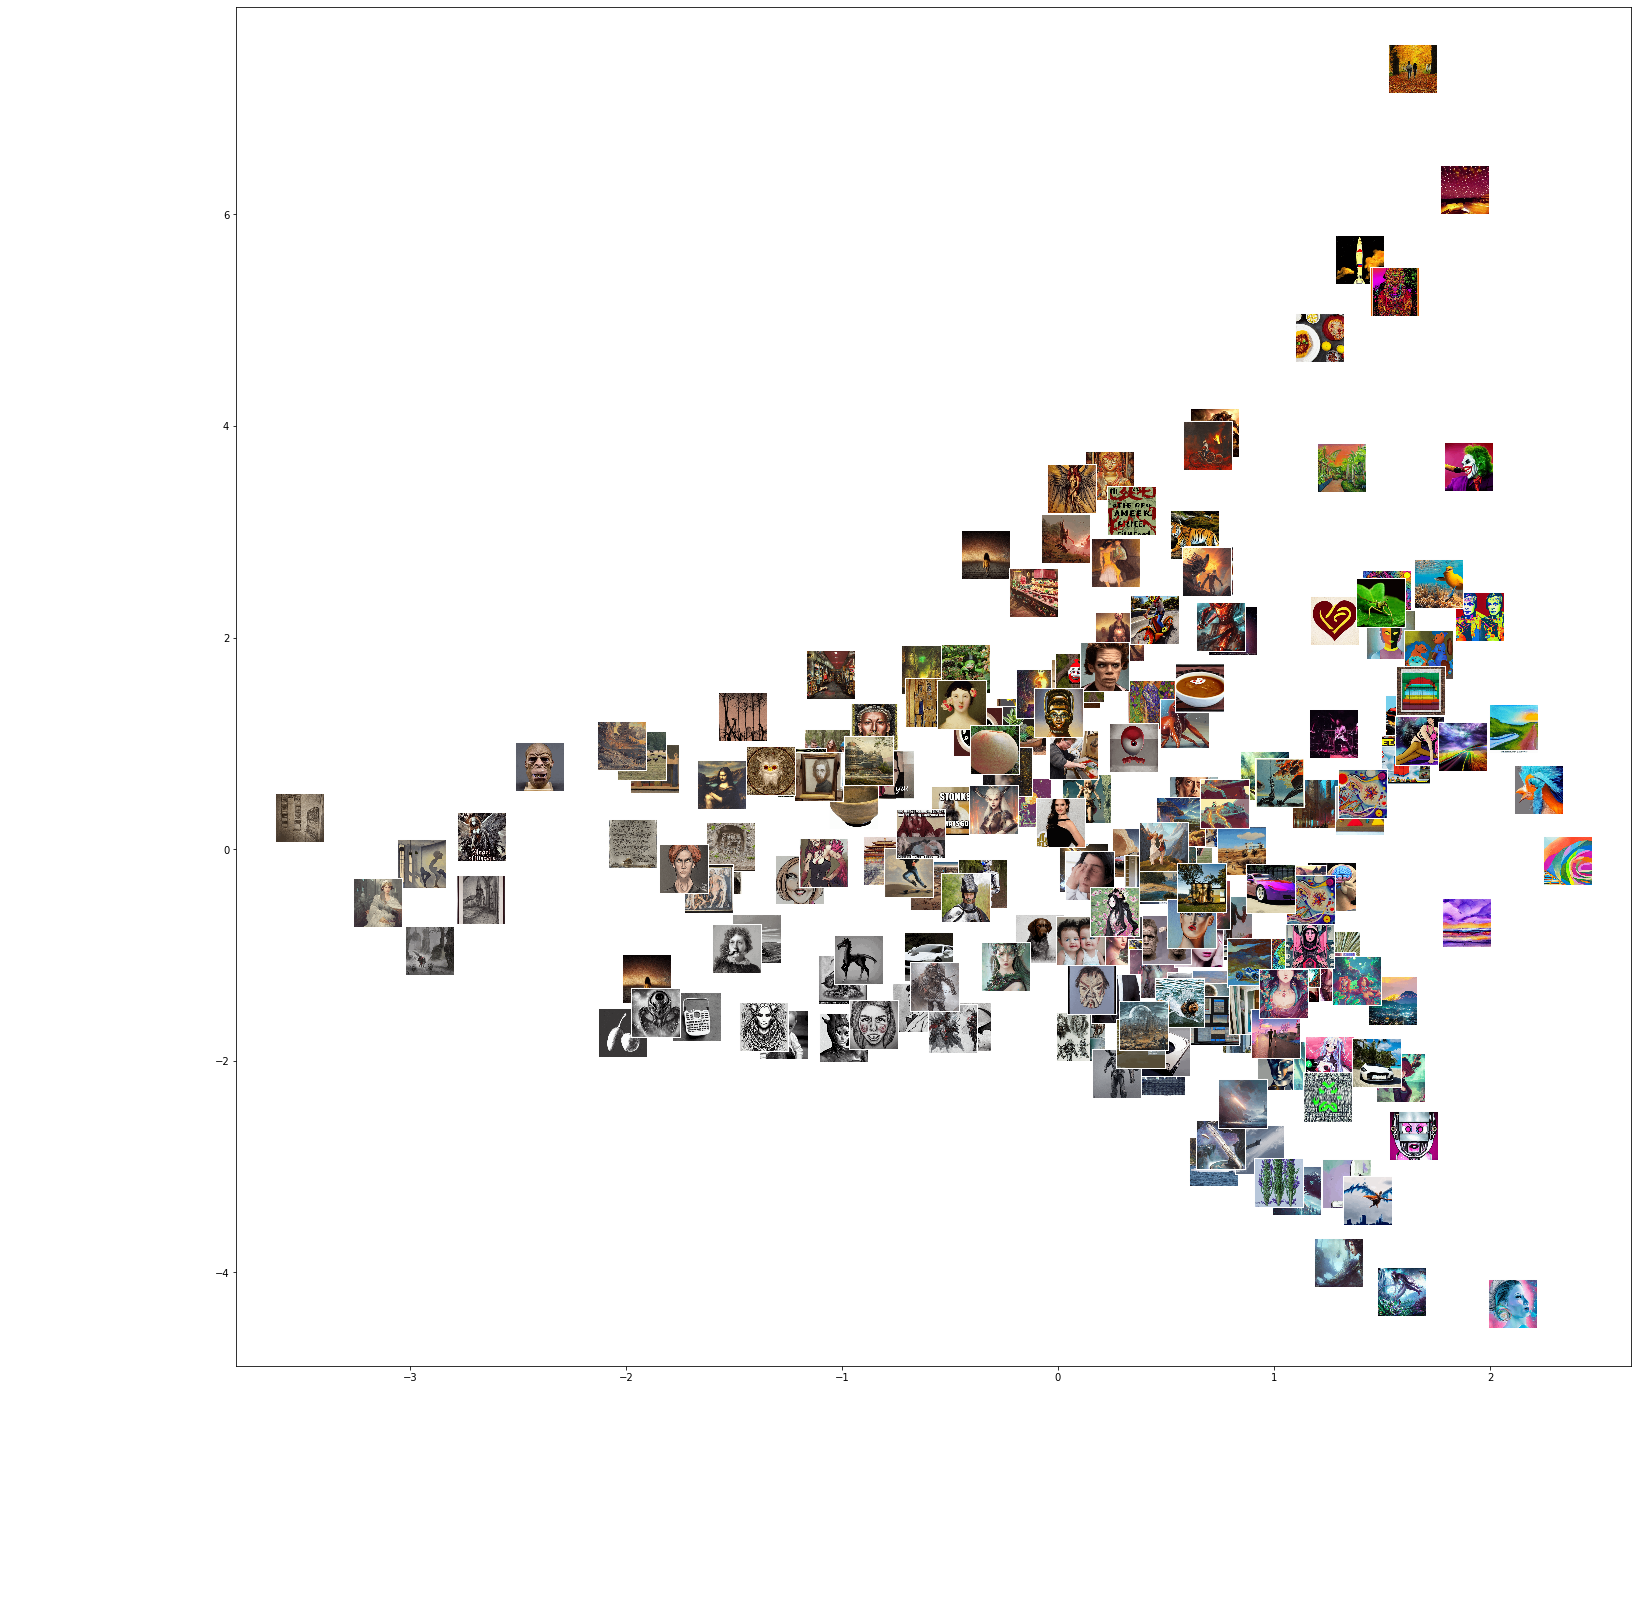

In [1772]:
show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])), 
               y_coords = pca_colour_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

# show_xy_images(x_coords = pca_colour_2d[-200:, 0], 
#                y_coords = pca_colour_2d[-200:, 1], 
#                img_arr_list = img_array_list[-200:])

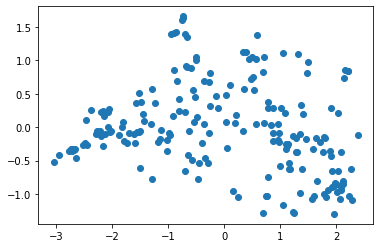

In [194]:
import matplotlib.pyplot as plt
plt.scatter(colour_2d[-200:, 0], colour_2d[-200:, 1])

In [1851]:
!mkdir ../raw_data/sac_images_subset4

In [1854]:
# check images are the correct size
# base_folder = '../raw_data/sac_images_subset/'
# [name for name in os.listdir(base_folder) if Image.open(f'{base_folder}/{name}').size[0] != 136]

[]

In [1852]:
import shutil

for path in image_path_list[-200:]:
    shutil.copy2(f'../raw_data/sac_images4/{path}', f'../raw_data/sac_images_subset4/{path}')

In [1847]:
def embedding_to_coords(embedding, scale = 1000, log = False):
    
    from_one = embedding + abs(embedding.min())
    
    if log:
        from_one = np.ma.log(from_one).filled(0)
        from_one = from_one + abs(from_one.min())
        
    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [1848]:
# take 200 images with the highest rating
import json

X_image_coords = embedding_to_coords(mde_image_2d[-200:, 0], scale = 1000)
Y_image_coords = embedding_to_coords(mde_image_2d[-200:, 1], scale = 1000)
X_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 0], scale = 1000, log = True)
Y_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 1], scale = 1000)

map_json = {
    "X_image_coords": X_image_coords,
    "Y_image_coords": Y_image_coords,
    "X_colour_coords": X_colour_coords,
    "Y_colour_coords": Y_colour_coords,
    "image_paths": image_path_list[-200:]
}

with open('../raw_data/sac4_latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


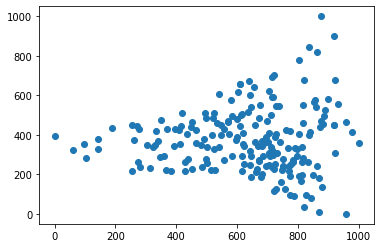

In [1849]:
plt.scatter(map_json['X_colour_coords'], map_json['Y_colour_coords'])

In [ ]:
# copy raw_data/sac_latent_space_map.json into the game assests folder

## Background

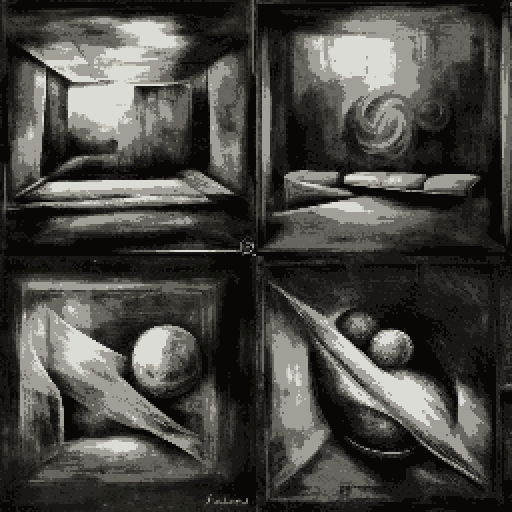

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')